## Convolutional neural network

In [19]:
import numpy as np

with np.load('cifar4-train.npz', allow_pickle = False) as npz_file:
    cifar4_data = dict(npz_file.items())
    
print(list(cifar4_data.keys()))

data = cifar4_data['pixels'].astype(np.float32)
y = cifar4_data['labels']

data = (data-128)/255
print('data:', data.shape, data.dtype)

['pixels', 'overfeat', 'labels', 'names', 'allow_pickle']
data: (5000, 3072) float32


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split data into train/test/ validation sets keeping same proportion of classes
X_tr, X_te, y_tr, y_te = train_test_split(data.reshape(-1, 32,32,3), cifar4_data['labels'], train_size=4000, test_size=1000, random_state=0, stratify=y)

X_tr, X_val, y_tr, y_val = train_test_split(X_tr, y_tr, train_size=3200, test_size=800, random_state=0, stratify=y_tr)

print('Train set:', X_tr.shape, y_tr.shape)
print('Validation set:', X_val.shape, y_val.shape)
print('Test set:', X_te.shape, y_te.shape)


Train set: (3200, 32, 32, 3) (3200,)
Validation set: (800, 32, 32, 3) (800,)
Test set: (1000, 32, 32, 3) (1000,)


In [7]:
#Batch generator
def get_batches(X, y, batch_size):
    shuffled_idx = np.arange(len(y))
    np.random.shuffle(shuffled_idx)
    
    for i in range(0, len(y), batch_size):
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

In [8]:
import tensorflow as tf
graph = tf.Graph()

with graph.as_default():
    X = tf.placeholder(dtype=tf.float32, shape=[None, 32,32,3])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    
    print('Input:', X.shape)
    
    #convolutional layer
    conv1 = tf.layers.conv2d(
        X, 64, (5,5), (2,2), 'SAME',
        activation = tf.nn.relu,
        kernel_initializer = tf.truncated_normal_initializer(stddev=0.01, seed=0),
        name = 'conv1')
    
    print('Convolutional layer:', conv1.shape)
    
    #maxpool layer
    pool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), 'SAME')
    print('Maxpool:', pool1.shape)
    
    
    # 2nd convolutional layer
    conv2 = tf.layers.conv2d(
        pool1, 64, (3,3), (1,1), 'SAME',
        activation = tf.nn.relu,
        kernel_initializer = tf.truncated_normal_initializer(stddev=0.01, seed=0),
        name = 'conv2')
    
    print('Convolutional layer:', conv2.shape)
    
    # 2nd maxpool layer
    pool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), 'SAME')
    print('Maxpool:', pool2.shape)
    
    flat_output = tf.contrib.layers.flatten(pool2)
    print('Flatten:', flat_output.shape)
        
    training = tf.placeholder(dtype=tf.bool)
    flat_output = tf.layers.dropout(flat_output, rate=0.5, seed=0, training=training)
    print('Dropout:', flat_output.shape)
    
    #fully connected layer
    fc1 = tf.layers.dense(
        flat_output, 256,
        activation = tf.nn.relu,
        kernel_initializer = tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer = tf.zeros_initializer())
    print('Fully-connected layer:', fc1.shape)
        
    logits = tf.layers.dense(
        fc1, 10,
        activation = None,
        kernel_initializer = tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer = tf.zeros_initializer())
    print('Output layer:', logits.shape)
             
    with tf.variable_scope('conv1', reuse=True):
        conv_kernels = tf.get_variable('kernel')
        
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))
      
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.AdamOptimizer(learning_rate=lr)
    
    train_op = gd.minimize(mean_ce)
        
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))
    

Input: (?, 32, 32, 3)
Convolutional layer: (?, 16, 16, 64)
Maxpool: (?, 8, 8, 64)
Convolutional layer: (?, 8, 8, 64)
Maxpool: (?, 4, 4, 64)
Flatten: (?, 1024)
Dropout: (?, 1024)
Fully-connected layer: (?, 256)
Output layer: (?, 10)


In [15]:
# Validation accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
   
    np.random.seed(0)
     
    for epoch in range(30):
        batch_acc = []
        
        for X_batch, y_batch in get_batches(X_tr, y_tr, 64):
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                lr: 0.001, # Learning rate
                training: True
            })
            
            batch_acc.append(acc_value)

        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_val,
            y: y_val,
            training: False
        })
        valid_acc_values.append(valid_acc)
        
        print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))
        
    kernels = conv_kernels.eval()
    
    # evaluate test accuracy
    test_acc = sess.run(accuracy, feed_dict={
        X: X_te,
        y: y_te,
        training: False
    })
    

Epoch 1 - valid: 0.468 train: 0.385 (mean)
Epoch 2 - valid: 0.545 train: 0.511 (mean)
Epoch 3 - valid: 0.571 train: 0.540 (mean)
Epoch 4 - valid: 0.587 train: 0.572 (mean)
Epoch 5 - valid: 0.629 train: 0.598 (mean)
Epoch 6 - valid: 0.635 train: 0.627 (mean)
Epoch 7 - valid: 0.666 train: 0.654 (mean)
Epoch 8 - valid: 0.690 train: 0.668 (mean)
Epoch 9 - valid: 0.700 train: 0.701 (mean)
Epoch 10 - valid: 0.717 train: 0.707 (mean)
Epoch 11 - valid: 0.723 train: 0.714 (mean)
Epoch 12 - valid: 0.711 train: 0.745 (mean)
Epoch 13 - valid: 0.739 train: 0.746 (mean)
Epoch 14 - valid: 0.714 train: 0.766 (mean)
Epoch 15 - valid: 0.731 train: 0.770 (mean)
Epoch 16 - valid: 0.749 train: 0.786 (mean)
Epoch 17 - valid: 0.745 train: 0.795 (mean)
Epoch 18 - valid: 0.757 train: 0.809 (mean)
Epoch 19 - valid: 0.756 train: 0.814 (mean)
Epoch 20 - valid: 0.765 train: 0.830 (mean)
Epoch 21 - valid: 0.757 train: 0.831 (mean)
Epoch 22 - valid: 0.754 train: 0.834 (mean)
Epoch 23 - valid: 0.764 train: 0.845 (mea

In [16]:
print('Convolutional network accuracy (test set): {:.3f}'.format(test_acc))

Convolutional network accuracy (test set): 0.785


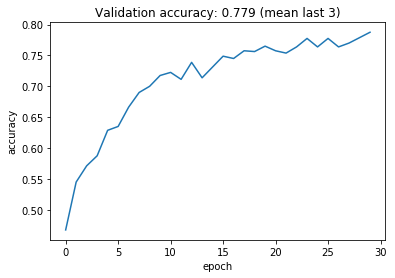

In [17]:
#plot accuracy on validation set

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(valid_acc_values)
plt.title('Validation accuracy: {:.3f} (mean last 3)'.format(
    np.mean(valid_acc_values[-3:]) 
))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

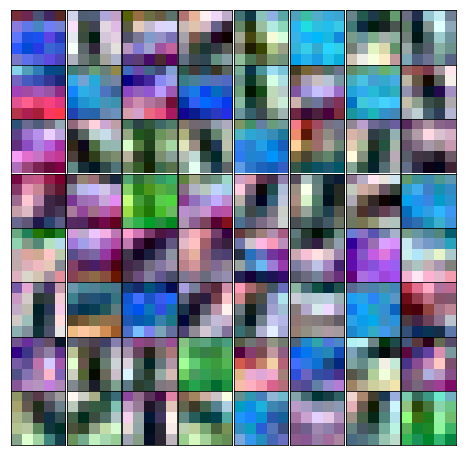

In [18]:
# plot the trained weights of the kernels from the first convolutional layer 

fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(8, 8))

plt.subplots_adjust(wspace=0, hspace=0)

for i, axis in enumerate(axes.flatten()):
    kernel = kernels[:, :, :, i].copy()
    
    kernel -= kernel.min() 
    kernel /= kernel.max() 
    
    axis.imshow(kernel)
    axis.get_xaxis().set_visible(False) 
    axis.get_yaxis().set_visible(False) 
    
plt.show()